In [117]:
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing, load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from graphviz import Source
from IPython.display import SVG
from scipy import linalg
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

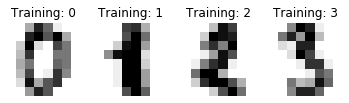

In [118]:
#load in the data
digits = load_digits()

#show ample digits
#taken from: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [119]:
#no need to scale this data
x = digits.data
y = digits.target

scaler = StandardScaler()
scaler.fit(x)
X = scaler.transform(x)

In [12]:
#expectation maximization
n_list = [1,2,3,4,5,10,15,20,30,40,50,75,100]
log = []

for n in n_list:
    print("Currently at cluster {}.".format(n))
    expmax = GaussianMixture(n_components=n, random_state=2)
    expmax.fit(X)
    log.append(expmax.lower_bound_) 

Currently at cluster 1.
Currently at cluster 2.
Currently at cluster 3.
Currently at cluster 4.
Currently at cluster 5.
Currently at cluster 10.
Currently at cluster 15.
Currently at cluster 20.
Currently at cluster 30.
Currently at cluster 40.
Currently at cluster 50.
Currently at cluster 75.
Currently at cluster 100.


Text(0, 0.5, 'lower bound log likelihood')

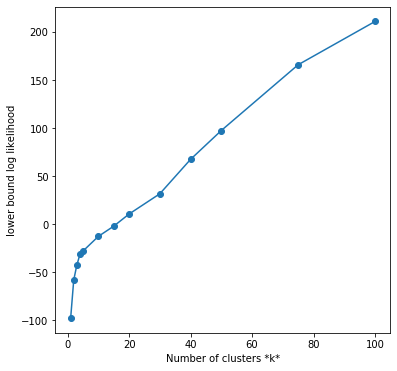

In [13]:
# Plot LL against k
plt.figure(figsize=(6, 6))
plt.plot(n_list, log, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('lower bound log likelihood')

In [120]:
#PCA for visualzation
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

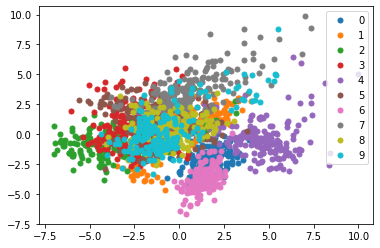

In [121]:
pc = pd.DataFrame(principalComponents,columns=['var0','var1'])
pc['category'] = pd.Series(y)
groups = pc.groupby('category')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.var0, group.var1, marker='o', linestyle='', ms=5, label=name)
ax.legend(numpoints=1)

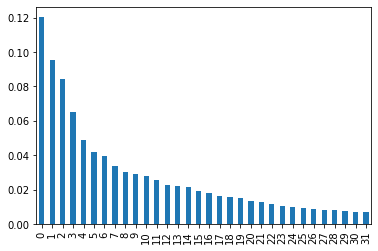

In [151]:
#Find best PCA dimsionality reduction
pca = PCA(n_components=32)
X_pca = pca.fit_transform(X)

ev = pd.DataFrame(pca.explained_variance_ratio_ , columns=['explained_variance_ratio'])
ev['explained_variance_ratio'].plot(kind='bar')

In [152]:
#best pca value
pca_best = PCA(n_components=8)
X_pca_best = pca.fit_transform(X)

C:\Users\tonyg\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\tonyg\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\tonyg\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\tonyg\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\tonyg\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Cons

Text(0, 0.5, 'kurtosis')

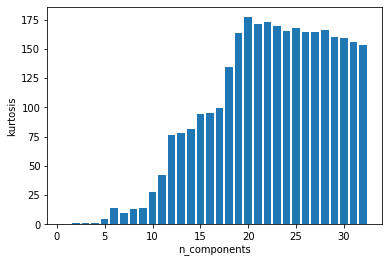

In [124]:
#find best ica for dimensionality reduction
n_list = [i+1 for i in range(32)]
kurtosis_list = []

for n in n_list:
    #print("calculating ICA for {} components".format(n))
    ica = FastICA(random_state=2, n_components=n)
    X_ica = pd.DataFrame(ica.fit_transform(X))
    kurtosis_list.append(X_ica.kurtosis(axis=0).abs().mean())

plt.bar(n_list,kurtosis_list)
plt.xlabel('n_components')
plt.ylabel('kurtosis')

In [184]:
#tranlsate data using optimal ica compoent value
ica_best = FastICA(random_state=2, n_components=20)
X_ica_best = ica.fit_transform(X)

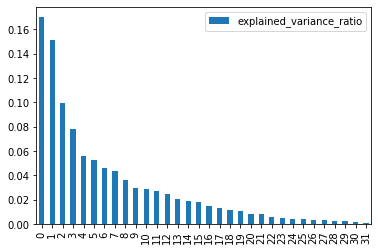

In [154]:
#Find best n for Random Projection
randproj = GaussianRandomProjection(n_components=32, random_state=2)
X_randproj = randproj.fit_transform(X)
n_samples, n_features = X_randproj.shape
U, S, V = linalg.svd(X_randproj, full_matrices=False)
exp_var = (S ** 2) / (n_samples - 1)
total_var = exp_var.sum()

ev = pd.DataFrame(exp_var / total_var, columns=['explained_variance_ratio'])
ev.plot(kind='bar')   

In [178]:
randproj_best = GaussianRandomProjection(n_components=8)
X_randproj_best = randproj_best.fit_transform(X)

In [128]:
#use a decision tree to do feature reduction
depth_list = range(1,21)
min_leaf_list = [0.001,.01,.02,.05]

clf = DecisionTreeClassifier(random_state=2)

gs = GridSearchCV(clf, cv=3, iid=False, param_grid={
    'max_depth': depth_list,
    'min_samples_leaf': min_leaf_list
    })

gs.fit(X, y)
print(gs.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best')


In [129]:
#find the columns that decision tree found useful
dt_features = list(set(list(pd.DataFrame(X).columns[gs.best_estimator_.tree_.feature])))
#filter new datset to only the features the decision tree found useful
X_dt_best = X[:,dt_features]

In [158]:
X_dt_best.shape

(1797, 41)

Text(0, 0.5, 'Sum of squared distance')

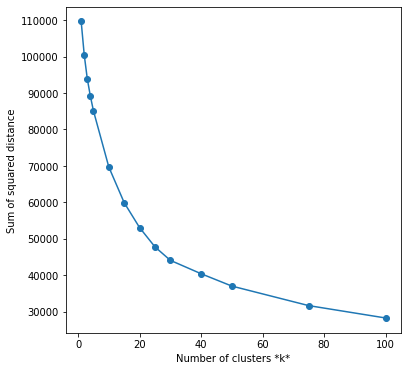

In [131]:
#K means on original dataset (normalized)
n_list = [1,2,3,4,5,10,15,20,25,30,40,50,75,100]
sse = []

for n in n_list:
    kmeans = KMeans(n_clusters=n, random_state=2)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(n_list, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Text(0, 0.5, 'Homogeneity')

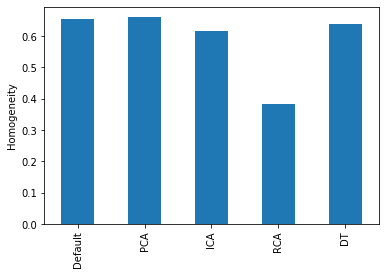

In [185]:
#show how feature reduction affects k means
sse = []

kmeans = KMeans(n_clusters=25,random_state=2)
kmeans.fit(X)
X_cluster = np.hstack((X,np.reshape(kmeans.predict(X), (-1,1))))
sse.append({'Reduction Type':'Default','Homogeniety':homogeneity_score(kmeans.predict(X),y)})
#PCA
kmeans.fit(X_pca_best)
X_pca_cluster = np.hstack((X,np.reshape(kmeans.predict(X_pca_best), (-1,1))))
sse.append({'Reduction Type':'PCA','Homogeniety':homogeneity_score(kmeans.predict(X_pca_best),y)})
#ICA
kmeans.fit(X_ica_best)
X_ica_cluster = np.hstack((X,np.reshape(kmeans.predict(X_ica_best), (-1,1))))
sse.append({'Reduction Type':'ICA','Homogeniety':homogeneity_score(kmeans.predict(X_ica_best),y)})
#RCA
kmeans.fit(X_randproj_best)
X_rca_cluster = np.hstack((X,np.reshape(kmeans.predict(X_randproj_best), (-1,1))))
sse.append({'Reduction Type':'RCA','Homogeniety':homogeneity_score(kmeans.predict(X_randproj_best),y)})
#DT
kmeans.fit(X_dt_best)
X_dt_cluster = np.hstack((X,np.reshape(kmeans.predict(X_dt_best), (-1,1))))
sse.append({'Reduction Type':'DT','Homogeniety':homogeneity_score(kmeans.predict(X_dt_best),y)})


#plot the results
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('Homogeneity')

In [180]:
sse_df

,Homogeniety,Reduction Type
0,0.652881,Default
1,0.660578,PCA
2,0.616847,ICA
3,0.381758,RCA
4,0.636701,DT


Text(0, 0.5, 'lower bound log likelihood')

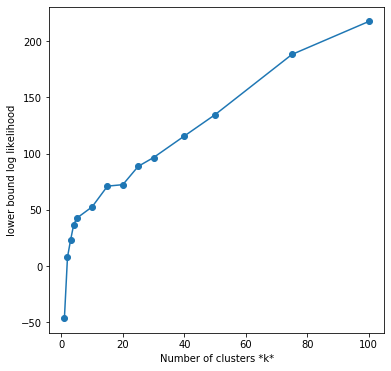

In [149]:
#expectation maximization
n_list = [1,2,3,4,5,10,15,20,25,30,40,50,75,100]
log = []

for n in n_list:
    expmax = GaussianMixture(n_components=n, random_state=2)
    expmax.fit(X)
    log.append(expmax.lower_bound_) 

# Plot sse against n
plt.figure(figsize=(6, 6))
plt.plot(n_list, log, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Lower bound log-likelihood')

Text(0, 0.5, 'Homogeneity')

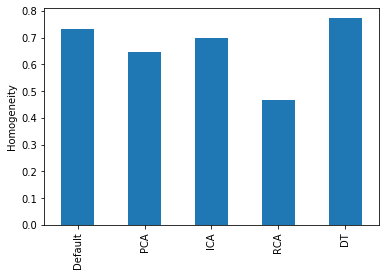

In [142]:
#show how feature reduction affects expectation maximization
sse = []

expmax = GaussianMixture(n_components=10, random_state=2)
#default data
expmax.fit(X)
sse.append({'Reduction Type':'Default','Homogeneity':homogeneity_score(expmax.predict(X),y)})
#PCA
expmax.fit(X_pca_best)
sse.append({'Reduction Type':'PCA','Homogeneity':homogeneity_score(expmax.predict(X_pca_best),y)})
#ICA
expmax.fit(X_ica_best)
sse.append({'Reduction Type':'ICA','Homogeneity':homogeneity_score(expmax.predict(X_ica_best),y)})
#RCA
expmax.fit(X_randproj_best)
sse.append({'Reduction Type':'RCA','Homogeneity':homogeneity_score(expmax.predict(X_randproj_best),y)})
#DT
expmax.fit(X_dt_best)
sse.append({'Reduction Type':'DT','Homogeneity':homogeneity_score(expmax.predict(X_dt_best),y)})

sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('Homogeneity')


In [137]:
sse_df

,Homogeneity,Reduction Type
0,0.732136,Default
1,0.646841,PCA
2,0.698935,ICA
3,0.320749,RCA
4,0.773340,DT


In [186]:
#Nerual Networks
sse = []

rows = np.sort(np.random.choice(X.shape[0], round(X.shape[0]*0.7), replace=False))
not_rows = [x for x in range(X.shape[0]) if x not in rows]


nn = MLPClassifier((9,6,6),solver='lbfgs', random_state = 2)
nn.fit(X[rows],y[rows])
sse.append({'Reduction Type':'Default','R^2':nn.score(X[not_rows],y[not_rows])})
#PCA
nn.fit(X_pca_best[rows],y[rows])
sse.append({'Reduction Type':'PCA','R^2':nn.score(X_pca_best[not_rows],y[not_rows])})
#ICA
nn.fit(X_ica_best[rows],y[rows])
sse.append({'Reduction Type':'ICA','R^2':nn.score(X_ica_best[not_rows],y[not_rows])})
#RCA
nn.fit(X_randproj_best[rows],y[rows])
sse.append({'Reduction Type':'RCA','R^2':nn.score(X_randproj_best[not_rows],y[not_rows])})
#DT
nn.fit(X_dt_best[rows],y[rows])
sse.append({'Reduction Type':'DT','R^2':nn.score(X_dt_best[not_rows],y[not_rows])})

Text(0, 0.5, 'Classification Accuracy')

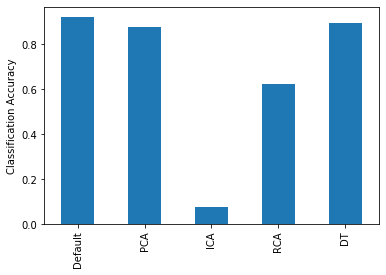

In [187]:
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('Classification Accuracy')

In [145]:
sse_df

,R^2,Reduction Type
0,0.864220,Default
1,0.801207,PCA
2,0.541544,ICA
3,0.293471,RCA
4,0.802218,DT


In [188]:
sse = []

#NN with cluster feature included
nn = MLPClassifier((6,8),solver='lbfgs', random_state = 2)
nn.fit(X_cluster[rows],y[rows])
sse.append({'Reduction Type':'Default','R^2':nn.score(X_cluster[not_rows],y[not_rows])})
#PCA
nn.fit(X_pca_cluster[rows],y[rows])
sse.append({'Reduction Type':'PCA','R^2':nn.score(X_pca_cluster[not_rows],y[not_rows])})
#ICA
nn.fit(X_ica_cluster[rows],y[rows])
sse.append({'Reduction Type':'ICA','R^2':nn.score(X_ica_cluster[not_rows],y[not_rows])})
#RCA
nn.fit(X_rca_cluster[rows],y[rows])
sse.append({'Reduction Type':'RCA','R^2':nn.score(X_rca_cluster[not_rows],y[not_rows])})
#DT
nn.fit(X_dt_cluster[rows],y[rows])
sse.append({'Reduction Type':'DT','R^2':nn.score(X_dt_cluster[not_rows],y[not_rows])})

Text(0, 0.5, 'R^2')

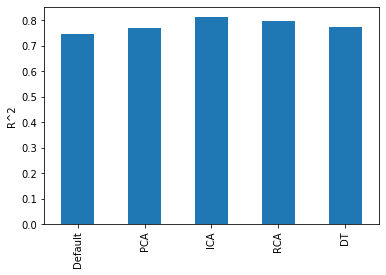

In [147]:
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('R^2')

In [148]:
sse_df

,R^2,Reduction Type
0,0.747698,Default
1,0.771329,PCA
2,0.812714,ICA
3,0.795444,RCA
4,0.773023,DT
